# XGBoost 20210926 GPU sweep
Trying after building GPU version locally

# Setup

In [1]:
# two manual flags (ex-config)
colab = False
gpu_available = True

In [2]:
# basic imports
from pathlib import Path
import os
import math
from datetime import datetime
import random
import multiprocessing
import pickle

In [3]:
%matplotlib inline
%config Completer.use_jedi = False
os.environ['WANDB_NOTEBOOK_NAME'] = f"sweep_xgboost_{datetime.now().strftime('%Y%m%d')}.ipynb"

In [4]:
# handle Google Colab-specific library installation/updating
if colab:
    # much of the below inspired by or cribbed from the May 2021 Kaggle Tabular Playground winner, at 
    # https://colab.research.google.com/gist/academicsuspect/0aac7bd6e506f5f70295bfc9a3dc2250/tabular-may-baseline.ipynb?authuser=1#scrollTo=LJoVKJb5wN0L
    
    # Kaggle API for downloading the datasets
    !pip install --upgrade -q kaggle

    # weights and biases
    !pip install -qqqU wandb
    
    # Optuna for parameter search
    !pip install -q optuna

    # !pip install --upgrade xgboost

    # upgrade sklearn
    !pip install --upgrade scikit-learn

    # !pip install category_encoders
    # !pip install catboost
#     !pip install --upgrade -q lightgbm

    # lighgbm gpu compatible
    # !git clone --recursive https://github.com/Microsoft/LightGBM
    # ! cd LightGBM && rm -rf build && mkdir build && cd build && cmake -DUSE_GPU=1 ../../LightGBM && make -j4 && cd ../python-package && python3 setup.py install --precompile --gpu;
    
    # # this part is from https://github.com/rapidsai/gputreeshap/issues/24
    # !pip install cmake --upgrade
    # # !pip install sklearn --upgrade
    # !git clone --recursive https://github.com/dmlc/xgboost
    # %cd /content/xgboost
    # !mkdir build
    # %cd build
    # !cmake .. -DUSE_CUDA=ON
    # !make -j4
    # %cd /content/xgboost/python-package
    # !python setup.py install --use-cuda --use-nccl
    # !/opt/bin/nvidia-smi
    # !pip install shap
    

Now, non-stdlib imports

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# general ML tooling
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import log_loss, roc_auc_score
import wandb
from optuna.integration.wandb import WeightsAndBiasesCallback
# from wandb.xgboost import wandb_callback
# from wandb.lightgbm import wandb_callback
# from sklearn.impute import KNNImputer, StandardImputer
# import timm

import seaborn as sns

# from catboost import CatBoostClassifier
from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
# from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MaxAbsScaler, StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures
# from sklearn.feature_selection import SelectKBest, f_regression
from joblib import dump, load
# feature engineering tools
# from sklearn.feature_selection import mutual_info_regression
# import featuretools as ft


from optuna.samplers import TPESampler
import optuna
# import catboost
from sklearn.utils import resample
import sklearn.metrics

Now, datapath setup

In [6]:
# # This is the code for reading the train.csv and converting it to a .feather file
# df = pd.read_csv(datapath/'train.csv', index_col='id', low_memory=False)
# df.index.name = None
# df.to_feather(path='./dataset_df.feather')

In [7]:
if colab:
    # mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    
    # handling datapath
#     datapath = Path('/content/drive/MyDrive/kaggle/tabular_playgrounds/sep2021/')
    
else:
    # if on local machine
#     datapath = Path('/media/sf/easystore/kaggle_data/tabular_playgrounds/sep2021/')  
    root = Path('/home/sf/code/kaggle/tabular_playgrounds/oct2021/')
    datapath = root/'datasets'
    edapath = root/'EDA'
    modelpath = root/'models'
    predpath = root/'preds'
    subpath = root/'submissions'
    studypath = root/'optuna_studies'
    
    for pth in [root, datapath, edapath, modelpath, predpath, subpath]:
        pth.mkdir(exist_ok=True)

In [8]:

# n_trials = int(1000)
SEED = 42

In [9]:
# Function to seed everything
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
seed_everything(SEED)

## Ex-Model Config

In [10]:
# meta-config for preprocessing and cross-validation, but NOT for model parameters
# in the sweep version, this includes both ex-model parameters and defaults for model parameters
exmodel_config = {
    # model config
    "library": 'xgboost',
#     "model": XGBClassifier,
#     "n_estimators": 100, 
#     "max_depth": 3,
#     "learning_rate": 0.1,
#     "test_size": 0.2,
#     "reg_lambda": None, 
#     "scaler": "sklearn.preprocessing.StandardScaler()", # TODO: experiment with others (but imputation may be slow)
#     "scale_b4_impute": False,
#     "imputer": "sklearn.impute.SimpleImputer(strategy='median', add_indicator=True)",
#     "knn_imputer_n_neighbors": None, # None if a different imputer is used
#     "feature_selector": SelectKBest,
#     "k_best": 80,
#     "feature_selection_scoring": f_regression,
    'random_state': SEED,
    'optuna': True,
    'optuna_trials': 50,
#     'subsample': 1,
#     'cross_val_strategy': None, # None for holdout, or the relevant sklearn class
#     'kfolds': 1, # if 1, that means just doing holdout
#     'test_size': 0.2,
    # these are XGBoost default (my choice) params 
#     "tree_method": "auto", # set to 'gpu_hist' to try GPU if available
#     "booster": 'gbtree', # dart may be marginally better, but will opt for this quicker approach as a default
#     "n_estimators": 200, 
#     "max_depth": 3,
#     "learning_rate": 0.1,
#     "n_jobs": -1,
#     "verbosity": 1,
#     "subsample": 1,
#     'features_created': False,
#     'feature_creator': None,
}

wandb_kwargs = {
    # wandb config
    'name': f"{os.environ['WANDB_NOTEBOOK_NAME'][:-6]}_{datetime.now().strftime('%H%M%S')}", # just removes the .ipynb extension, leaving the notebook filename's stem
    'project': '202110_Kaggle_tabular_playground',
    'tags': ['sweep'],
    'notes': "Sweep for XGBoost on GPU with Optuna",
    'config': exmodel_config,
}

## Data Setup

**TODO** Write some conditional logic here to automate it -- possibly as part of a sklearn.*pipeline

In [11]:
train_source = datapath/'train.feather'
df = pd.read_feather(path=train_source)
df.index.name = 'id'
y_train = df.target
features = [x for x in df.columns if x != 'target']
X_train = df[features]
# X.index.name = 'id'
# y.index.name = 'id'
X = np.array(X_train)
y = np.array(y_train)

# del df, X_train, y_train


# exmodel_config['feature_count'] = len(X.columns)
exmodel_config['feature_count'] = X.shape[1]
exmodel_config['instance_count'] = X.shape[0]

# exmodel_config['feature_generator'] = None
# exmodel_config['feature_generator'] = "Summary statistics"

exmodel_config['train_source'] = str(train_source)
test_source = datapath/'test.feather'
exmodel_config['test_source'] = str(test_source)
X_test = pd.read_feather(path=test_source)
# X_test = X_test.iloc[:, 1:]
X_test = np.array(X_test)

# Experiment setup

In [12]:
# wandb_kwargs = {
#     # wandb config:
#     'name': f"{os.environ['WANDB_NOTEBOOK_NAME'][:-6]}_{datetime.now().strftime('%H%M%S')}", # just removes the .ipynb extension, leaving the notebook filename's stem
#     'project': '202109_Kaggle_tabular_playground',
#     'tags': ['sweep'],
#     'notes': "Sweep for CatBoost using Optuna",
#     'config': exmodel_config,
# }

In [25]:
# originally from https://www.kaggle.com/satorushibata/optimize-catboost-hyperparameter-with-optuna-gpu
def objective(trial):
    # split the (original Kaggle training) data into partitions
    # if study.best_trial:
    #     print("Dumping best params, which are:")
    #     print(str(study.best_trial.params))
    #     dump(study.best_trial.params, filename=datapath/'optuna_catboost_best_20210920.joblib')
       
    # else:
    #     print("No best study yet")
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=int(SEED), shuffle=True)
    # create wrappers for the training and validation partitions
    # train_pool = catboost.Pool(X_train, y_train)
    # valid_pool = catboost.Pool(X_valid, y_valid)
    
    # experimental parameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 900, 6000), # was 900-4500 for CPU
        'max_depth' : trial.suggest_int('depth', 3, 10),                                       
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.4),               
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.001, 30),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 0.001, 30),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1),
#         'booster': trial.suggest_categorical('boosting_type', ['gbtree', 'dart']),
        'min_child_weight': trial.suggest_uniform('min_child_weight', 0.001, 10),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1),
        'gamma': trial.suggest_uniform('gamma', 0.1, 30)
    }  

    # instantiate the model, with some parameters locked in, and experimnental ones passed via splat 
    model = XGBClassifier(
        objective='binary:logistic',
        verbosity=1,
        tree_method='gpu_hist',
        booster='gbtree', # not bothering with dart for time reasons
        random_state=SEED,
#         n_jobs=-1,
        **params
    )    

    model.fit(X_train, y_train)
    # generate predictions
    preds = model.predict_proba(X_valid)[:,1]
    # rounds to the nearest integer, and the nearest even in case of _.5s

    # Evaluation
    valid_auc = roc_auc_score(y_valid, preds)
    print('ROC AUC Score of XGBoost =', valid_auc)
    wandb.log({'valid_auc': valid_auc,
              })

    return valid_auc

In [26]:
wandbc = WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs)

<ipython-input-26-69ea9289a2cf>:1: ExperimentalWarning:

WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.



In [27]:
# study = optuna.create_study(direction = "maximize", 
#                             sampler = TPESampler(seed=int(SEED)), 
#                             study_name=f"xgboost_{datetime.now().strftime('%Y%m%d')}")

study = load(studypath/f"optuna_xgboost_study_106trials_20211004.joblib")


In [16]:
import torch

In [23]:
import xgboost

In [24]:
xgboost.core.XGBoostError?

Init signature: xgboost.core.XGBoostError(self, /, *args, **kwargs)
Docstring:      Error thrown by xgboost trainer.
File:           ~/anaconda3/envs/tabular-x/lib/python3.8/site-packages/xgboost/core.py
Type:           type
Subclasses:     


In [29]:
study.optimize?

Signature:
study.optimize(
    func: Callable[[optuna.trial._trial.Trial], Union[float, Sequence[float]]],
    n_trials: Union[int, NoneType] = None,
    timeout: Union[float, NoneType] = None,
    n_jobs: int = 1,
    catch: Tuple[Type[Exception], ...] = (),
    callbacks: Union[List[Callable[[ForwardRef('Study'), optuna.trial._frozen.FrozenTrial], NoneType]], NoneType] = None,
    gc_after_trial: bool = False,
    show_progress_bar: bool = False,
) -> None
Docstring:
Optimize an objective function.

Optimization is done by choosing a suitable set of hyperparameter values from a given
range. Uses a sampler which implements the task of value suggestion based on a specified
distribution. The sampler is specified in :func:`~optuna.study.create_study` and the
default choice for the sampler is TPE.
See also :class:`~optuna.samplers.TPESampler` for more details on 'TPE'.

Example:

    .. testcode::

        import optuna


        def objective(trial):
            x = trial.suggest_float("

In [ ]:
# dump(study, filename=datapath/f"optuna_xgboost_100trials-complete_{datetime.now().strftime('%Y%m%d')}.joblib")
# dump(study.best_trial.params, filename=datapath/f"optuna_lightgbm_all-500trials-best_{datetime.now().strftime('%Y%m%d')}.joblib")
# pickle.dump(study.best_trial.params, open('CatBoost_Hyperparameter.pickle', 'wb'))
# print('CatBoost Hyperparameter:', study.best_trial.params)

In [31]:
study.best_trial.params

{'n_estimators': 3878,
 'depth': 4,
 'learning_rate': 0.024785857161974977,
 'reg_alpha': 26.867682044658245,
 'reg_lambda': 10.839759074147148,
 'subsample': 0.8208581489835881,
 'min_child_weight': 8.829122644339664,
 'colsample_bytree': 0.906420714280384,
 'gamma': 1.472322916021486}

In [32]:
wandb.log({'xgboost_params': study.best_trial.params})
wandb.finish()

colsample_bytree,▄▅▅▄▃▂▅▄▁▄▆▇██▇▇▇███▇▇▇▇▇▇▇█▇▇▇██▇█▆▇█▇▇
depth,▂▂▃▁▃███▃▅▃▃▃▃▅▂▃▃▂▂▁▂▁▂▂▁▁▂▂▂▁▂▂▂▂▂▂▂▂▂
gamma,▅▅▆▃▇▅▆▅█▄▁▁▁▁▂▂▁▁▂▂▂▁▂▂▂▂▁▂▂▂▃▃▁▂▂▁▂▂▁▂
learning_rate,▃▄▁▂▁▁▃▂█▂▃▃▃▅▂▃▃▄▃▇▆▄▄▆▅█▅▇▃▄▅▆▃▃▄▂▄▃▃▄
min_child_weight,▂▂▂▅▂▃▇▂▄▁▅▅▆▆▇▆▅▅▇▇▆▇▇▇▇▇▇▇▇▇█▇▇▇▇▇█▇█▇
n_estimators,▄▄▃▇▄██▆▅▂▆▆▆▅▅▅▆▆▅▅▁▅▅▅▅▆▄▄▅▆▅▅▆▆▅▅▅▅▆▅
reg_alpha,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▇█▅▆▂▆▆▂▄█▄▄▅▂▃▂▁█▁
reg_lambda,▁▁▁▁▁▁▁▁▁▁▃▄▄▄█▅▂▄▆▆▂▄▂▂▁▃▅▂▁▁▂▃▂▃▆▃▅▇▅▅
subsample,▅▄▃▁▂▃▅▆▄▁▅▅▅▆▆▅▅▇▇▇▆▅▅▆▆█▆▅▆▆▆█▆▆▅▆▆▆▇▆
valid_auc,██▅▇▁███▇▅███████▇█▇▆██████████████▇████
value,██▅▇▁███▇▅███████▇█▇▆██████████████▇████


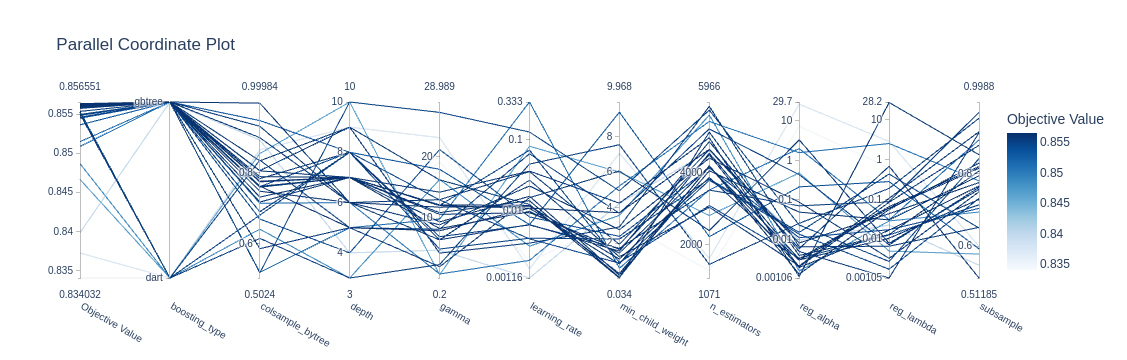

In [33]:
optuna.visualization.plot_parallel_coordinate(study)